In [9]:
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
#import helper_functions as helper

In [10]:
import os
#give path to the IPN Analysis
path = '/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis'
os.chdir(path)

In [11]:
#Reading the file, BP filtering
local_path= '/global/cfs/cdirs/m2043/roybens/ben-shalom_nas/raw_data/MEASlices_02242025_PVSandCA/MEASlices_02242025_PVSandCA/250224/M07305/Network/000005/data.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path,stream_id = 'well002')
freq_min = 300
freq_max = 4500


#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=freq_min, freq_max=freq_max)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 10000.0
Number of channels: 1020
Number of segments: 1
total_recording: 300.0 s
chunk duration: 300.0 s


In [12]:
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
%matplotlib widget
# Visualize the traces interactively
print("Visualizing traces interactively...")
sw.plot_timeseries(recording_chunk, mode='line', show_channel_ids=True,backend='ipywidgets')


Visualizing traces interactively...


/home/miniconda3/lib/python3.8/site-packages/spikeinterface/widgets/widget_list.py:148: UserWarning: plot_timeseries() is now plot_traces()
  warnings.warn("plot_timeseries() is now plot_traces()")


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

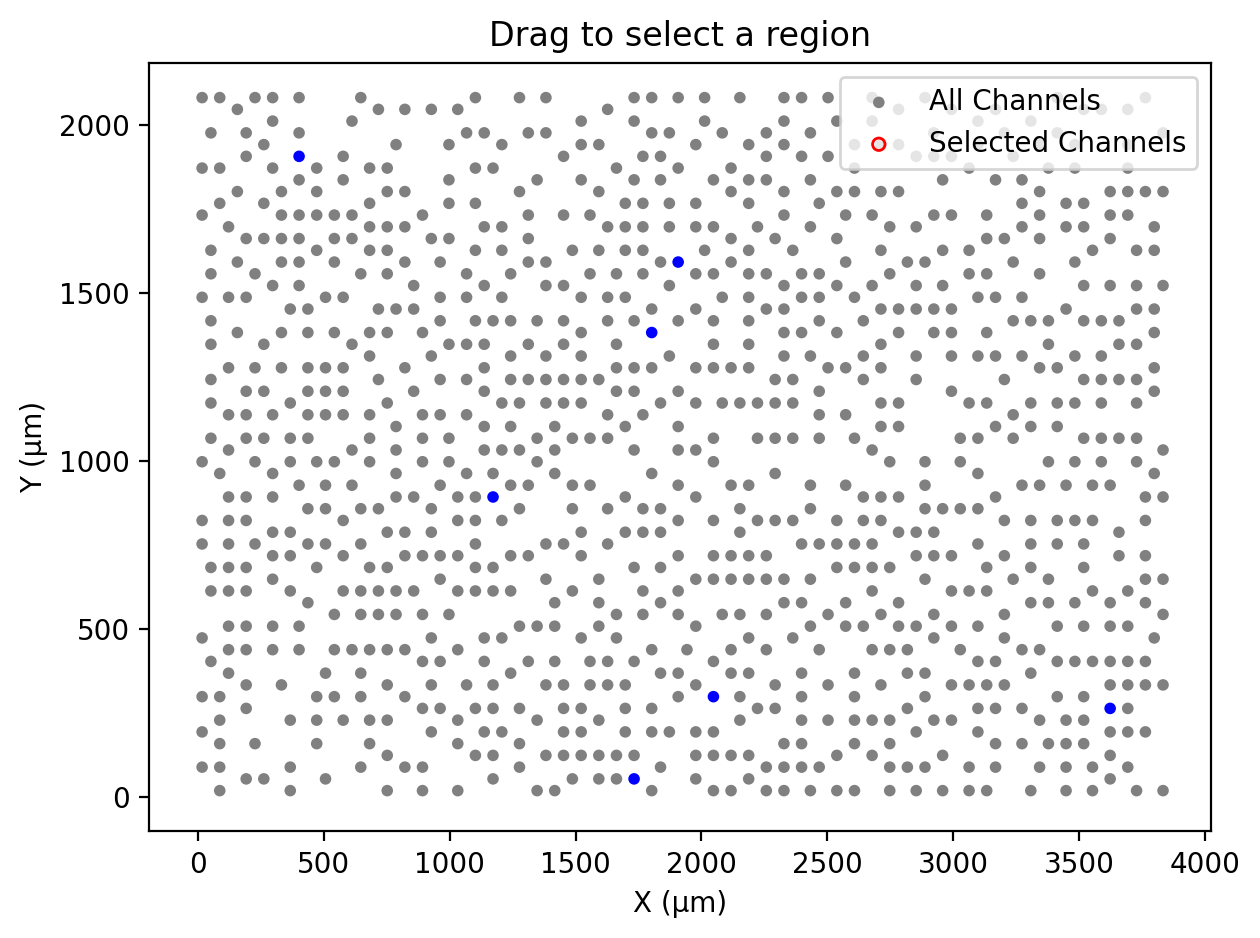

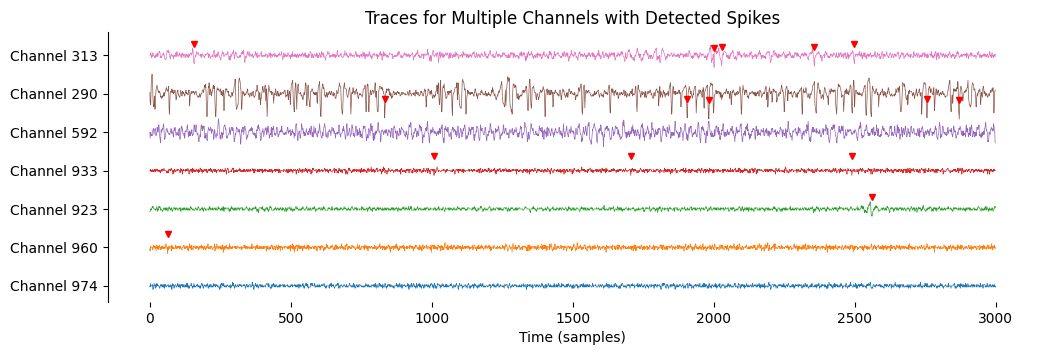

In [13]:
import os

import numpy as np
import matplotlib.pyplot as plt
from helper_functions import detect_peaks_stddev  # Import the detect_peaks function
%matplotlib inline
channels_to_plot = [974,960,923,933,592,290,313] 
fs = recording_chunk.get_sampling_frequency()
start_time = 42.75 # Start time in seconds
end_time = 43.05 # End time in seconds
# Get traces for the specified range
traces = recording_chunk.get_traces(start_frame=int(start_time*fs), end_frame=int(end_time*fs), segment_index=0, return_scaled=True)

# Define the channels you want to plot
 # Replace with the desired channel indices
#channels_to_plot = range(traces.shape[1])  # Example channel indices
# Parameters for spike detection
peak_sign = "neg"  # Detect negative peaks
std_multiplier = 4 # Threshold: 1 standard deviation from the mean

# Adjust figure height dynamically based on the number of channels
plt.figure(figsize=(12, len(channels_to_plot) * 0.5))  # Increase height for better spacing

# Loop through the channels and plot each
yticks_positions = []  # Store y-axis positions for labeling
yticks_labels = []  # Store channel names for labeling

for i, channel in enumerate(channels_to_plot):
    # Get the trace for the current channel
    trace = traces[:, channel]
    
    # Detect peaks using the detect_peaks function
    peaks_sample_inds, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    
    # Convert peaks_sample_inds to integers
    peaks_sample_inds = peaks_sample_inds.astype(int)
    spike_marker_offset = 100
    
    # Plot the trace with increased spacing
    plt.plot(
        trace + i * 200,  # Increase the offset to 200 for better spacing
        label=f'Channel {channel}', 
        rasterized=True,  # Rasterize the line plots for faster rendering
        linewidth=0.5  # Use thinner lines for better performance
    )
    
    # Mark the detected spikes with red triangles
    plt.plot(
        peaks_sample_inds, 
        trace[peaks_sample_inds] + i * 200 + spike_marker_offset,  # Match the increased offset
        'rv',  # Red triangles
        markersize=4, 
        label=f'Spikes Channel {channel}'
    )
    
    # Add y-axis tick position and label
    yticks_positions.append(i * 200)
    yticks_labels.append(f'Channel {channel}')

# Customize the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time (samples)')
plt.title('Traces for Multiple Channels with Detected Spikes')

# Add y-axis ticks with channel names
plt.yticks(yticks_positions, yticks_labels)

# Save the plot as a PDF
output_path = './savetraces_multiple_channels_with_spikes.pdf'  # Replace with your desired path
plt.show() 
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=150)  # Save with high resolution
 # Show the plot
# Close the plot to free memory
plt.close()

In [14]:
# Extract channel IDs and 2D location coordinates
channel_ids =np.array([int(x) for x in recording_chunk.get_channel_ids()])
locs = recording_chunk.get_channel_locations()
channels_to_highlight = [974,960,923,933,592,290,313]  # Channels to highlight



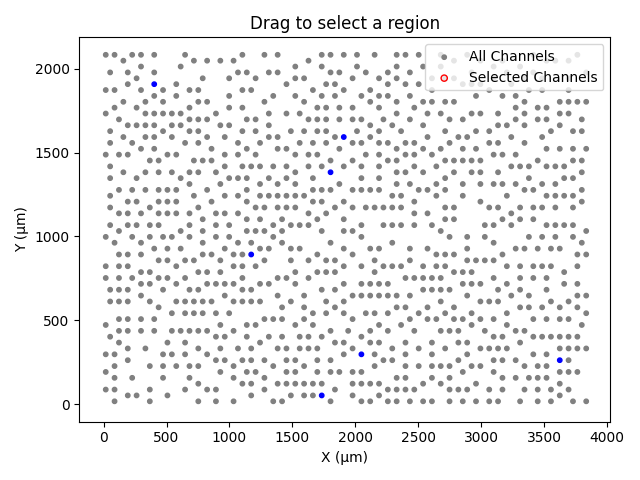

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
import ipywidgets as widgets
from IPython.display import display
import os

# Enable interactive matplotlib
%matplotlib widget

# Setup figure
fig, ax = plt.subplots()
c = ['gray'] * len(channel_ids)  # Default color for all channels
for ch in channels_to_highlight: 
    if ch in channel_ids:
        idx = np.where(channel_ids == ch)[0][0]
        c[idx] = 'blue'  # Highlight specified channels in red   

sc = ax.scatter(locs[:, 0], locs[:, 1], c=c, label='All Channels', s=10)
ax.set_title("Drag to select a region")
ax.set_xlabel("X (μm)")
ax.set_ylabel("Y (μm)")

# Scatter for selected points
selected_plot = ax.scatter([], [], facecolors='none', edgecolors='red', linewidths=1, s=20, label='Selected Channels')
selected_channels = []

# Create an output widget for displaying messages
output = widgets.Output()

# Selection callback with cumulative selection
def onselect(eclick, erelease):
    global selected_channels
    if eclick.xdata is None or erelease.xdata is None:  # Ignore clicks outside the plot
        return

    x0, y0 = eclick.xdata, eclick.ydata
    x1, y1 = erelease.xdata, erelease.ydata

    mask = (
        (locs[:, 0] > min(x0, x1)) & (locs[:, 0] < max(x0, x1)) &
        (locs[:, 1] > min(y0, y1)) & (locs[:, 1] < max(y0, y1))
    )
    new_selection = channel_ids[mask]

    # Check if Ctrl key is pressed (use event modifiers)
    if eclick.key == 'control':  # Append to existing selection
        selected_channels = np.unique(np.concatenate((selected_channels, new_selection)))
    else:  # Overwrite selection
        selected_channels = new_selection

    selected_plot.set_offsets(locs[np.isin(channel_ids, selected_channels)])
    fig.canvas.draw_idle()

    # Display the selection details in the output widget
    with output:
        output.clear_output()  # Clear previous messages
        print(f"🔴 Selected {len(selected_channels)} channels")
        print(selected_channels)

# Create RectangleSelector
selector = RectangleSelector(
    ax, onselect,
    interactive=True,
    useblit=True,
    button=[1]
)

# Create save button
save_button = widgets.Button(
    description="💾 Save Selected Channels",
    button_style='success',
    tooltip='Save selected channel IDs to file'
)

# Define callback to save to file
def save_selected_channels_to_file(b):
    if len(selected_channels) == 0:
        with output:
            output.clear_output()
            print("No channels selected to save.")
        return

    save_path = "selected_channels.txt"
    with open(save_path, "w") as f:
        for ch in selected_channels:
            f.write(f"{ch}\n")

    with output:
        output.clear_output()
        print(f"Saved {len(selected_channels)} channel IDs to {os.path.abspath(save_path)}")

# Attach callback and show button
save_button.on_click(save_selected_channels_to_file)

# Display the save button and output widget
display(widgets.VBox([save_button, output]))

plt.legend()
plt.tight_layout()
plt.show()